
 # Stellar Analytics: Exoplanet Habitability Classification and Index Development


 **Overview**

 This notebook details the process of analyzing an exoplanet dataset, engineering relevant features, developing a custom "Habitability Index," and building a classification model to categorize exoplanets based on their potential to support life. The goal is to identify potentially habitable, marginally habitable, and non-habitable planets. This document corresponds to the requirements of Round 1 of the Stellar Analytics problem, addressing data preprocessing, feature engineering, and model building.


 **Problem Statement (from provided document)**

 The project aims to:

 1.  Clean and preprocess an exoplanet dataset, handling missing values, outliers, and redundant features.
 2.  Engineer new features (like ESI, stability metrics, and atmospheric retention estimates) that are relevant to habitability.
 3.  Develop a custom "Habitability Index" that combines multiple factors to score a planet's potential for life.
 4.  Build a multi-class classification model to categorize planets into:
     *   **Potentially Habitable:**  Conditions are conducive to liquid water.
     *   **Marginally Habitable:** Extreme, but not impossible, conditions for life.
     *   **Non-Habitable:** No realistic possibility of life as we know it.
 5.  Create visualizations to display model results.



 **Assumptions (from provided document and clarified)**

 *   The `P_HABITABLE` column contains values 0, 1, and 2, representing:
     *   **0:** Non-habitable
     *   **1:** Potentially habitable (requiring adaptation, i.e., marginally habitable)
     *   **2:** Earth-like (potentially habitable)


 **Approach**

 The approach taken in this notebook follows these major steps:

 1.  **Data Loading and Inspection:** Load the dataset and examine its structure, data types, and descriptive statistics.
 2.  **Handling Missing Values:** Impute missing values using appropriate strategies (median for numerical, mode for categorical).
 3.  **Outlier Removal:** Identify and remove outliers using IQR and DBSCAN methods.
 4.  **Feature Engineering:**
     *   **Feature Dropping:** Remove irrelevant or redundant columns (identifiers, text representations, etc.).
     *   **One-Hot Encoding:** Convert categorical features into numerical representations.
     *   **Derived Features:** Calculate new features like mass ratio, temperature difference from optimal, a custom ESI, a revised ESI, orbital and star age stability scores, and an atmospheric retention estimate.
     *   **Habitability Score:** Create a combined habitability score.
     *   **Feature Reduction:**  Use Variance Threshold to eliminate low-variance features.
 5.  **Data Splitting and Scaling:** Divide the data into training and testing sets, and scale the numerical features using `StandardScaler`.
 6.  **Addressing Class Imbalance:** Use SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes in the training data.
 7.  **Model Training:** Train and evaluate Logistic Regression and Random Forest classifiers.
 8.  **Feature Importance Analysis:** Analyze the feature importances from the Random Forest model.
 9.  **Weighted Hab Index:** Create a weighted habitability index.
 10. **Retraining with Hab Index:** Retrain models with the habitability index.
 11. **Confusion Matrix:** Generate and display the confusion matrix.


 ### Imports

 The necessary libraries are imported.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.cluster import DBSCAN
from sklearn.feature_selection import VarianceThreshold


 ### Data Loading

In [2]:
try:
    df = pd.read_csv('exoplanet_dataset.csv')
except FileNotFoundError:
    print(
        "Error: exoplanet_dataset.csv not found.  Make sure the file is in the "
        "correct directory."
    )
    exit()

df.head()

,P_NAME,P_DETECTION,P_DISCOVERY_FACILITY,P_YEAR,P_UPDATE,P_MASS,P_MASS_ORIGIN,P_RADIUS,P_PERIOD,P_SEMI_MAJOR_AXIS,...,S_SNOW_LINE,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG
0,OGLE-2016-BLG-1227L b,Microlensing,OGLE,2020,2020-04-02,250.00,Mass,13.90,NaN,3.4000,...,NaN,NaN,0.214133,0,0,NaN,0,Scorpius,Sco,Scorpion
1,Kepler-276 c,Transit,Kepler,2013,2018-09-25,16.60,Mass,2.90,31.884000,0.1994,...,2.437046,2.097783,0.316980,0,0,Hot,0,Cygnus,Cyg,Swan
2,Kepler-829 b,Transit,Kepler,2016,2019-04-16,5.10,M-R relationship,2.11,6.883376,0.0678,...,2.827247,1.756317,0.459559,0,0,Hot,0,Lyra,Lyr,Lyre
3,K2-283 b,Transit,K2,2018,2019-09-05,12.20,M-R relationship,3.52,1.921036,0.0291,...,1.476943,0.568374,0.443760,0,0,Hot,0,Pisces,Psc,Fishes
4,Kepler-477 b,Transit,Kepler,2016,2019-04-16,4.94,M-R relationship,2.07,11.119907,0.0911,...,1.759397,0.768502,0.386150,0,0,Hot,0,Lyra,Lyr,Lyre



 The exoplanet dataset is loaded using `pd.read_csv`. A `try-except` block handles the potential `FileNotFoundError` gracefully, providing a helpful message to the user and exiting if the file isn't found. The first few rows are displayed using `.head()` to give a quick overview of the data.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5599 entries, 0 to 5598
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   P_NAME                5599 non-null   object 
 1   P_DETECTION           5599 non-null   object 
 2   P_DISCOVERY_FACILITY  5599 non-null   object 
 3   P_YEAR                5599 non-null   int64  
 4   P_UPDATE              5599 non-null   object 
 5   P_MASS                5592 non-null   float64
 6   P_MASS_ORIGIN         5599 non-null   object 
 7   P_RADIUS              5592 non-null   float64
 8   P_PERIOD              5350 non-null   float64
 9   P_SEMI_MAJOR_AXIS     5595 non-null   float64
 10  P_ECCENTRICITY        4822 non-null   float64
 11  P_INCLINATION         4288 non-null   float64
 12  P_OMEGA               1659 non-null   float64
 13  S_NAME                5599 non-null   object 
 14  S_NAME_HD             971 non-null    object 
 15  S_NAME_HIP           


 Displays a concise summary of the DataFrame.  This is important for quickly identifying missing data and understanding the data types of each column.

In [4]:
df.describe()

,P_YEAR,P_MASS,P_RADIUS,P_PERIOD,P_SEMI_MAJOR_AXIS,P_ECCENTRICITY,P_INCLINATION,P_OMEGA,S_RA,S_DEC,...,P_FLUX,P_TEMP_EQUIL,P_TEMP_SURF,S_LUMINOSITY,S_SNOW_LINE,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_HABITABLE
count,5599.000000,5592.000000,5592.000000,5.350000e+03,5595.000000,4822.000000,4288.000000,1659.000000,5599.000000,5599.000000,...,5.365000e+03,5365.000000,2441.000000,5.366000e+03,5366.000000,5.376000e+03,5595.000000,5599.000000,5599.000000,5599.000000
mean,2016.188962,442.521283,5.715494,7.994082e+04,6.307151,0.076407,86.862548,119.026000,236.798083,19.586974,...,8.430605e+02,792.985586,971.994023,8.007960e+00,3.596167,1.014471e+35,0.425790,0.047151,0.033577,0.019825
std,4.527714,2369.505048,5.331450,5.498596e+06,130.676333,0.150524,10.556374,119.422173,90.260234,35.843622,...,1.745120e+04,484.434177,487.382871,1.110798e+02,6.741964,5.259131e+36,0.077064,0.211981,0.180155,0.184617
min,1992.000000,0.020000,0.310000,9.070629e-02,0.004400,0.000000,0.370000,-233.000000,0.185606,-88.121111,...,3.289901e-10,1.084914,130.661650,8.128305e-07,0.002434,4.356319e-05,0.029269,0.000000,0.000000,0.000000
25%,2014.000000,4.040000,1.780000,4.465382e+00,0.052750,0.000000,86.900000,28.300000,183.518215,-7.826301,...,1.053177e+01,456.758880,638.352490,3.580964e-01,1.615711,4.781093e-01,0.391256,0.000000,0.000000,0.000000
50%,2016.000000,8.750000,2.780000,1.156951e+01,0.102100,0.000000,88.760500,104.490000,285.930740,39.883080,...,6.735305e+01,727.306290,908.701120,8.590135e-01,2.502441,1.361846e+00,0.443760,0.000000,0.000000,0.000000
75%,2020.000000,162.092490,11.900000,4.150555e+01,0.284600,0.090000,89.670000,210.000000,293.579330,45.434686,...,2.923345e+02,1049.902400,1204.326300,2.058263e+00,3.873593,2.556535e+00,0.470516,0.000000,0.000000,0.000000
max,2024.000000,89700.000000,77.342000,4.020000e+08,7506.000000,0.950000,176.092000,395.341000,359.974980,85.736533,...,8.793103e+05,7800.730100,8125.496300,6.309573e+03,214.468620,2.726899e+38,1.003328,1.000000,1.000000,2.000000



 Provides descriptive statistics (count, mean, std, min, max, quartiles) for the numerical columns. This gives a quick sense of the data distributions and potential outliers.


 ### Finding Null

In [5]:
df.isnull().sum()

P_NAME                     0
P_DETECTION                0
P_DISCOVERY_FACILITY       0
P_YEAR                     0
P_UPDATE                   0
P_MASS                     7
P_MASS_ORIGIN              0
P_RADIUS                   7
P_PERIOD                 249
P_SEMI_MAJOR_AXIS          4
P_ECCENTRICITY           777
P_INCLINATION           1311
P_OMEGA                 3940
S_NAME                     0
S_NAME_HD               4628
S_NAME_HIP              4579
S_TYPE                  3578
S_RA                       0
S_DEC                      0
S_RA_STR                   0
S_DEC_STR                  0
S_MAG                    219
S_DISTANCE                21
S_TEMPERATURE            219
S_MASS                     4
S_RADIUS                 232
S_METALLICITY            433
S_AGE                   1207
S_LOG_LUM                235
S_LOG_G                  246
P_ESCAPE                   7
P_POTENTIAL                7
P_GRAVITY                  7
P_DENSITY                  7
P_HILL_SPHERE 


 This step calculates and displays the number of missing values (NaNs) in each column. This is crucial for understanding data completeness and deciding how to handle missing data (imputation).


 ### Removing Null

In [6]:
numeric_cols = df.select_dtypes(include=np.number).columns
imputer = SimpleImputer(strategy='median')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])


 This code addresses missing numerical values.  `SimpleImputer` with `strategy='median'` replaces missing values with the median of each column. The median is robust to outliers.

In [7]:
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


 This handles missing values in categorical (object type) columns.  It fills missing values with the *mode* (most frequent value) of each column.  The mode is appropriate for categorical data.

In [8]:
df.isnull().sum()

P_NAME                  0
P_DETECTION             0
P_DISCOVERY_FACILITY    0
P_YEAR                  0
P_UPDATE                0
P_MASS                  0
P_MASS_ORIGIN           0
P_RADIUS                0
P_PERIOD                0
P_SEMI_MAJOR_AXIS       0
P_ECCENTRICITY          0
P_INCLINATION           0
P_OMEGA                 0
S_NAME                  0
S_NAME_HD               0
S_NAME_HIP              0
S_TYPE                  0
S_RA                    0
S_DEC                   0
S_RA_STR                0
S_DEC_STR               0
S_MAG                   0
S_DISTANCE              0
S_TEMPERATURE           0
S_MASS                  0
S_RADIUS                0
S_METALLICITY           0
S_AGE                   0
S_LOG_LUM               0
S_LOG_G                 0
P_ESCAPE                0
P_POTENTIAL             0
P_GRAVITY               0
P_DENSITY               0
P_HILL_SPHERE           0
P_DISTANCE              0
P_PERIASTRON            0
P_APASTRON              0
P_DISTANCE_E


 *Confirmation Check*: This verifies that all missing values have been handled.


 ### Data Preprocessing

In [9]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[
        (df[column] >= lower_bound) & (df[column] <= upper_bound)
    ]
    return df_filtered


 This function, `remove_outliers_iqr`, removes outliers from a specified column using the Interquartile Range (IQR) method. The IQR is calculated, and data points outside 1.5 times the IQR from the first and third quartiles are considered outliers and removed.  This is a standard method for outlier removal in normally distributed data.

In [10]:
columns_to_clean_iqr = [
    'P_MASS',
    'P_RADIUS',
    'P_PERIOD',
    'P_SEMI_MAJOR_AXIS',
    'S_LUMINOSITY',
    'P_FLUX',
    'P_TEMP_EQUIL',
]


 These columns are selected for IQR-based outlier removal because they represent physical planetary and stellar properties where extreme values could significantly skew the analysis and have clear positive and negative trends.

In [11]:
for col in columns_to_clean_iqr:
    df = remove_outliers_iqr(df, col)


 The `remove_outliers_iqr` function is applied iteratively to each selected column.  This ensures outliers are removed progressively.

In [12]:
correlation_matrix = df[columns_to_clean_iqr].corr()


 A correlation matrix is calculated *after* the initial IQR-based outlier removal.  This is important because outliers can distort correlation coefficients.

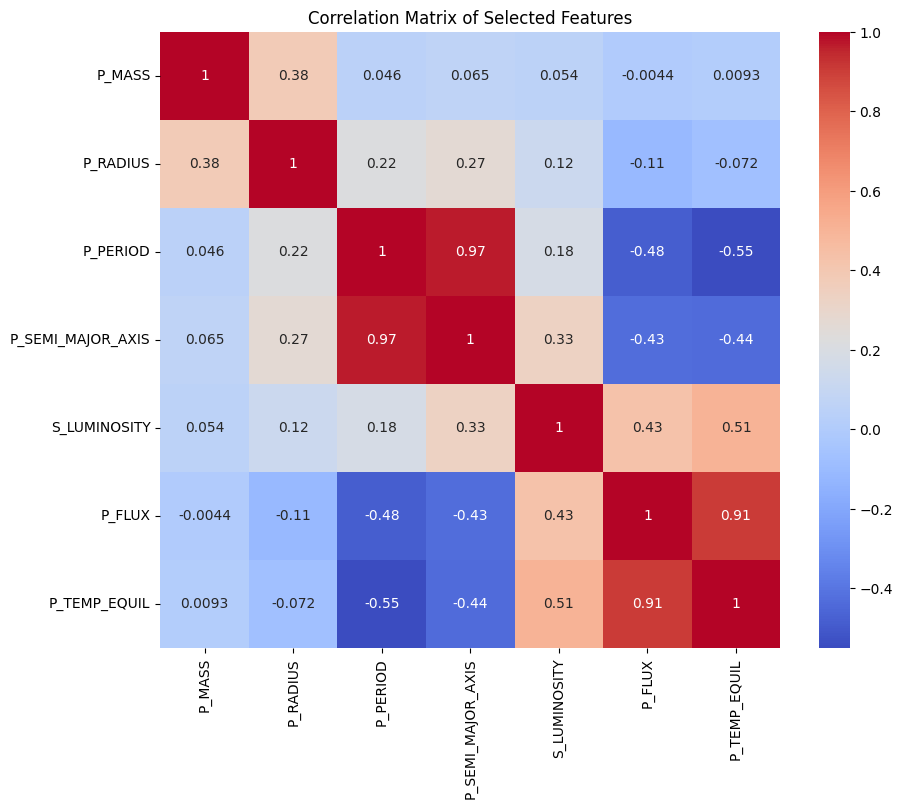

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Selected Features')
plt.show()


 The correlation matrix is visualized as a heatmap.  `annot=True` displays the correlation coefficients, and `cmap='coolwarm'` provides a visual color scale. This helps understand linear relationships between the selected features.

In [14]:
def remove_outliers_dbscan(df, x_col, y_col, eps=0.5, min_samples=5):
    """Removes outliers based on DBSCAN clustering in 2D space."""
    data = df[[x_col, y_col]].copy()  # Create a copy to avoid modifying original
    data = data.dropna()  # Remove rows with NaN in either column
    if len(data) == 0:
        print("Warning: No data left after dropping NaNs for DBSCAN.")
        return df  # Return original if no data

    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(scaled_data)

    # Identify outliers (-1 label)
    outlier_indices = np.where(clusters == -1)[0]

    # Get the indices of the outliers in the original dataframe
    outlier_rows = data.iloc[outlier_indices].index

    # Remove outliers from the original dataframe
    df_filtered = df.drop(outlier_rows)
    return df_filtered


 This function uses the DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm to identify and remove outliers. DBSCAN is useful for identifying outliers in non-linear relationships, unlike IQR.  The function takes two columns, scales the data, applies DBSCAN, and removes points identified as noise (outliers).

In [15]:
df = remove_outliers_dbscan(df, 'P_RADIUS', 'P_MASS', eps=0.3, min_samples=5)


 DBSCAN is applied to `P_RADIUS` and `P_MASS`. These two are expected to have a relationship, but unusual densities might be present. `eps=0.3` and `min_samples=5` were chosen empirically.


 ### Exploratory Data Analysis

In [16]:
def visualise_p_mass_vs_p_radius():
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='P_RADIUS', y='P_MASS', data=df)
    plt.title('Planet Mass vs. Radius (Outliers Removed)')
    plt.show()

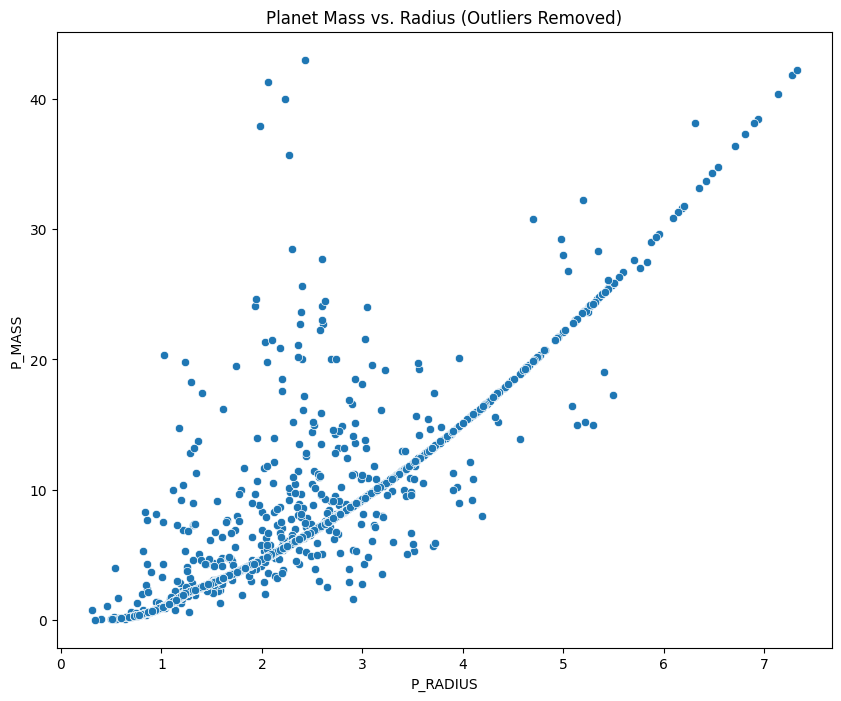

In [17]:
visualise_p_mass_vs_p_radius()


 A scatter plot visualizes the relationship between `P_RADIUS` and `P_MASS` *after* outlier removal. This allows us to see the trend and any remaining unusual points.

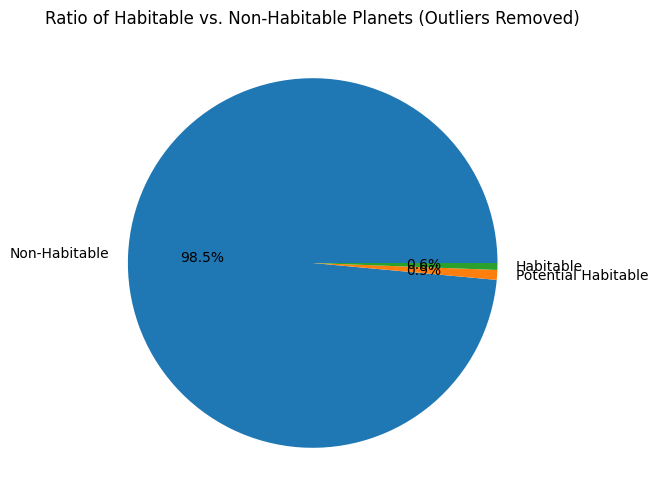

In [18]:
habitable_counts = df['P_HABITABLE'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(
    habitable_counts,
    labels=['Non-Habitable',"Potential Habitable" ,'Habitable'],
    autopct='%1.1f%%',
)
plt.title('Ratio of Habitable vs. Non-Habitable Planets (Outliers Removed)')
plt.show()


 This creates a pie chart showing the distribution of habitability categories *after* outlier removal.  It provides a visual representation of class imbalance.


 ## Feature Engineering

In [19]:
columns_to_drop = [
    'P_NAME',  # Identification columns
    'P_DETECTION',
    'P_DISCOVERY_FACILITY',
    'P_UPDATE',
    'P_MASS_ORIGIN',
    'S_NAME',
    'S_NAME_HD',
    'S_NAME_HIP',
    'S_RA_STR',
    'S_DEC_STR',
    'S_RA_TXT',
    'S_DEC_TXT',
    'S_CONSTELLATION',
    'S_CONSTELLATION_ABR',
    'S_CONSTELLATION_ENG',
    'P_YEAR',  # Discovery year isn't relevant for habitability
]


 These columns are dropped because they are irrelevant for predicting habitability:
 *   **Identifiers:** Unique names/IDs don't contribute to habitability prediction.
 *   **Redundant Information:** String versions of numerical data are unnecessary.
 *   **Irrelevant for Habitability:** Discovery method, facility, update date, and year don't affect intrinsic habitability.

In [20]:
df_cleaned = df.drop(columns=columns_to_drop)


 The selected columns are removed.

In [21]:
categorical_columns = ['P_TYPE', 'S_TYPE', 'S_TYPE_TEMP', 'P_TYPE_TEMP']
df_encoded = pd.get_dummies(df_cleaned, columns=categorical_columns)


 Categorical features are converted to numerical representations using one-hot encoding.  This creates binary columns for each category, making the data suitable for machine learning algorithms.

In [22]:
df_encoded['MASS_RATIO'] = df_encoded['P_MASS'] / df_encoded['S_MASS']


 `MASS_RATIO` (planet mass / star mass) is created.  This relative size can be relevant to habitability.

In [23]:
optimal_temp = 288  # approx earch temp in kelvin
df_encoded['TEMP_DIFF_FROM_OPTIMAL'] = abs(
    df_encoded['P_TEMP_SURF'] - optimal_temp
)


 `TEMP_DIFF_FROM_OPTIMAL` calculates the absolute temperature difference from Earth's average (288 K).  This quantifies deviation from a potentially habitable temperature.


 Combined Hab Score

In [24]:
df_encoded['HAB_SCORE'] = (
    df_encoded['P_HABZONE_OPT'] + df_encoded['P_HABZONE_CON']
) / 2


 A combined habitability score (`HAB_SCORE`) is created by averaging `P_HABZONE_OPT` and `P_HABZONE_CON`.

In [25]:
def calculate_esi_custom(
    planet_radius,
    earth_radius,
    planet_density,
    earth_density,
    planet_temp,
    earth_temp,
):
    """Calculates a simplified Earth Similarity Index (ESI) based on radius, density, and temperature."""
    radius_term = 1 - abs(
        (planet_radius - earth_radius) / (planet_radius + earth_radius)
    )
    density_term = 1 - abs(
        (planet_density - earth_density) / (planet_density + earth_density)
    )
    temp_term = 1 - abs(
        (planet_temp - earth_temp) / (planet_temp + earth_temp)
    )

    esi = (
        radius_term * density_term * temp_term
    ) ** (1 / 3)  # Geometric mean
    return esi


# Earth values (approximate)
earth_radius = 1  # Earth radii
earth_density = 5.51  # g/cm^3
earth_temp = 288  # K

df_encoded['ESI_CUSTOM'] = df_encoded.apply(
    lambda row: calculate_esi_custom(
        row['P_RADIUS'],
        earth_radius,
        row['P_DENSITY'],
        earth_density,
        row['P_TEMP_SURF'],
        earth_temp,
    ),
    axis=1,
)

# Rationale: ESI provides a single metric to compare a planet's similarity to Earth
# based on radius, density and temperature.


 A custom Earth Similarity Index (`ESI_CUSTOM`) is calculated based on radius, density, and temperature, providing a single metric for similarity to Earth.  The geometric mean ensures that a low value in any one term reduces the overall ESI.

In [26]:
def calculate_esi_revised(planet_stellar_flux, earth_stellar_flux, planet_radius, earth_radius):
    """Calculates the Earth Similarity Index (ESI) using the revised formula based on stellar flux and radius."""
    flux_term = ((planet_stellar_flux - earth_stellar_flux) / (planet_stellar_flux + earth_stellar_flux))**2
    radius_term = ((planet_radius - earth_radius) / (planet_radius + earth_radius))**2
    esi = 1 - (0.5 * (flux_term + radius_term))**0.5
    return esi

# Earth values (approximate)
earth_stellar_flux = 1367  # W/m^2 (Solar constant) - Approximate value
earth_radius = 1  # Earth radii

# Apply the revised ESI calculation
df_encoded['ESI_REVISED'] = df_encoded.apply(
    lambda row: calculate_esi_revised(
        row['P_FLUX'],
        earth_stellar_flux,
        row['P_RADIUS'],
        earth_radius,
    ),
    axis=1,
)

# Rationale: ESI provides a single metric to compare a planet's similarity to Earth
# based on stellar flux and radius, using a more physically relevant formula.


 A revised Earth Similarity Index (`ESI_REVISED`) is calculated based on stellar flux and radius.

In [27]:
# 5. Approximate Long-Term Stability (based on eccentricity and star age)
df_encoded['ORBITAL_STABILITY'] = 1 - df_encoded['P_ECCENTRICITY']
# Rationale: Lower eccentricity generally indicates a more stable orbit.

df_encoded['STAR_AGE_SCORE'] = 1 / (
    1 + df_encoded['S_AGE']
)  # Normalize star age (older = less stable)
# Rationale: Younger stars might be more active, leading to less stable planetary conditions.

df_encoded['COMBINED_STABILITY'] = (
    df_encoded['ORBITAL_STABILITY'] + df_encoded['STAR_AGE_SCORE']
) / 2
# Rationale: Combines orbital stability and star age for a more comprehensive stability metric.


 Orbital and stellar stability features are engineered:
 *   `ORBITAL_STABILITY`:  `1 - P_ECCENTRICITY`. Lower eccentricity means a more circular, stable orbit.
 *   `STAR_AGE_SCORE`: `1 / (1 + S_AGE)`.  Younger stars are assumed more active, less stable.
 *   `COMBINED_STABILITY`: Averages the above two, giving a combined stability measure.

In [28]:
# 6. Approximate Atmospheric Retention (based on gravity and temperature)
df_encoded['ATMOSPHERIC_RETENTION'] = df_encoded['P_GRAVITY'] / (
    1 + (df_encoded['P_TEMP_SURF'] / 100)
)
# Rationale: Higher gravity and lower temperature favor atmospheric retention.
# The division by temperature is scaled down to avoid overly strong influence.


 `ATMOSPHERIC_RETENTION` is estimated.  Higher gravity retains atmosphere; higher temperature leads to escape. Temperature is scaled to moderate its influence.

In [29]:
print("\nFinal dataset shape:", df_encoded.shape)


Final dataset shape: (2670, 189)



 Prints the shape of the final DataFrame (rows, columns), confirming feature count and sample count.

In [30]:
# Feature Reduction using Variance Threshold
X = df_encoded.drop('P_HABITABLE', axis=1)
y = df_encoded['P_HABITABLE']

selector = VarianceThreshold(
    threshold=0.01
)  # Features with variance below 0.01 will be removed
X_reduced = selector.fit_transform(X)

# Get the indices of the selected features
selected_features_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features = X.columns[selected_features_indices]

print("Selected features:", selected_features)

X = df_encoded[selected_features]

Selected features: Index(['P_MASS', 'P_RADIUS', 'P_PERIOD', 'P_INCLINATION', 'P_OMEGA', 'S_RA',
       'S_DEC', 'S_MAG', 'S_DISTANCE', 'S_TEMPERATURE', 'S_MASS', 'S_RADIUS',
       'S_METALLICITY', 'S_AGE', 'S_LOG_LUM', 'S_LOG_G', 'P_ESCAPE',
       'P_POTENTIAL', 'P_GRAVITY', 'P_DENSITY', 'P_FLUX', 'P_TEMP_EQUIL',
       'P_TEMP_SURF', 'S_LUMINOSITY', 'S_SNOW_LINE', 'S_ABIO_ZONE',
       'P_HABZONE_OPT', 'P_TYPE_Neptunian', 'P_TYPE_Subterran',
       'P_TYPE_Superterran', 'P_TYPE_Terran', 'S_TYPE_G0 V', 'S_TYPE_M0 V',
       'S_TYPE_M1 V', 'S_TYPE_TEMP_F', 'S_TYPE_TEMP_G', 'S_TYPE_TEMP_K',
       'S_TYPE_TEMP_M', 'P_TYPE_TEMP_Hot', 'P_TYPE_TEMP_Warm', 'MASS_RATIO',
       'TEMP_DIFF_FROM_OPTIMAL', 'HAB_SCORE', 'ESI_CUSTOM', 'ESI_REVISED',
       'STAR_AGE_SCORE', 'ATMOSPHERIC_RETENTION'],
      dtype='object')



 Feature reduction is done with `VarianceThreshold`. Features with low variance (nearly constant) are removed.  This simplifies the model and removes uninformative features. The threshold (0.01) is chosen empirically.


 ## Train/Test Split and Scaling

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


 Data is split into training (80%) and testing (20%) sets. `random_state=42` ensures reproducibility. `stratify=y` maintains class distribution in both sets (critical for imbalanced data).

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


 Numerical features are scaled using `StandardScaler` (mean 0, standard deviation 1). This is important for algorithms sensitive to feature scaling.


 ## SMOTE

In [33]:
smote = SMOTE(random_state=42, sampling_strategy="auto")
X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train_scaled, y_train
)


 SMOTE (Synthetic Minority Over-sampling Technique) addresses class imbalance.  It creates synthetic samples of minority classes, preventing bias towards the majority class. `sampling_strategy="auto"` automatically determines the number of synthetic samples.


 ## Model Training and Evaluation


 ### Logistic Regression

In [34]:
lr = LogisticRegression(
    class_weight='balanced', max_iter=1000, random_state=42
)  # class_weight='balanced'
lr.fit(X_train_resampled, y_train_resampled)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)


 A Logistic Regression model is trained.  `class_weight='balanced'` handles class imbalance. `max_iter=1000` ensures convergence. `random_state=42` ensures reproducibility. Training uses *resampled* data.

In [35]:
y_pred_lr = lr.predict(X_test_scaled)


 Predictions are made on the scaled *test* data.

In [36]:
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Performance:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       526
         1.0       1.00      1.00      1.00         5
         2.0       1.00      1.00      1.00         3

    accuracy                           1.00       534
   macro avg       1.00      1.00      1.00       534
weighted avg       1.00      1.00      1.00       534




 `classification_report` provides precision, recall, F1-score, and support for each class.


 ### Random Forest

In [37]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
)  # class_weight='balanced'
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=5,
                       random_state=42)


 A Random Forest classifier is trained. `n_estimators=100` sets the number of trees.  `max_depth=5` and `min_samples_leaf=5` prevent overfitting. `class_weight='balanced'` addresses imbalance. Training uses resampled data.

In [38]:
y_pred_rf = rf.predict(X_test_scaled)


 Predictions are made on the scaled test data.

In [39]:
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))

Random Forest Performance:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       526
         1.0       1.00      1.00      1.00         5
         2.0       1.00      1.00      1.00         3

    accuracy                           1.00       534
   macro avg       1.00      1.00      1.00       534
weighted avg       1.00      1.00      1.00       534




 The `classification_report` is printed.


 ## Feature Importance

In [40]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)


 Feature importances from the Random Forest are extracted and sorted.

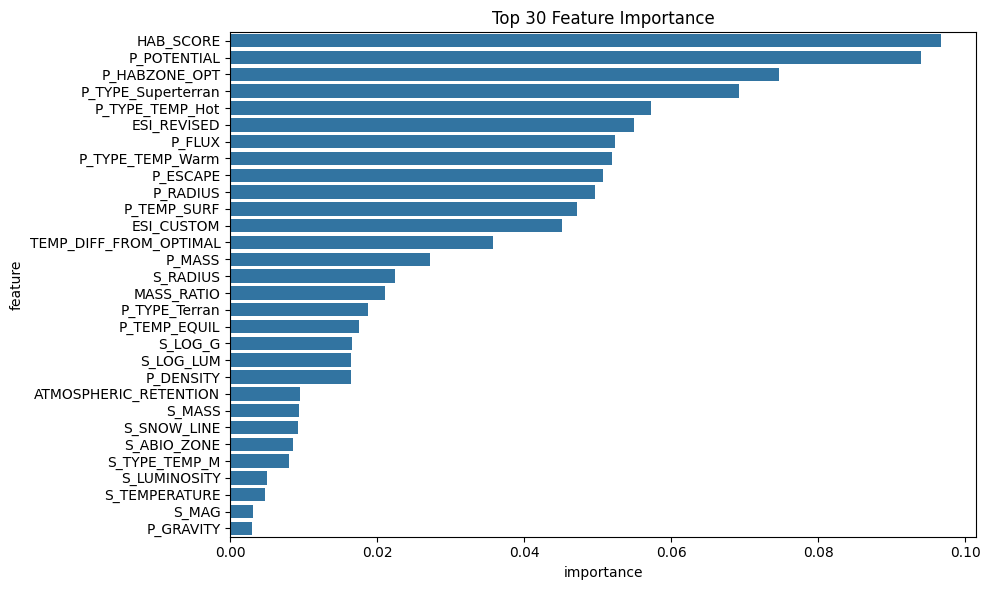

In [41]:
plt.figure(figsize=(10, 6))
top_10_features = feature_importance.head(30)
sns.barplot(x='importance', y='feature', data=top_10_features)
plt.title('Top 30 Feature Importance')
plt.tight_layout()
plt.show()


 A bar plot shows the top 30 most important features.


 ### Visualizations to Check for Overfitting

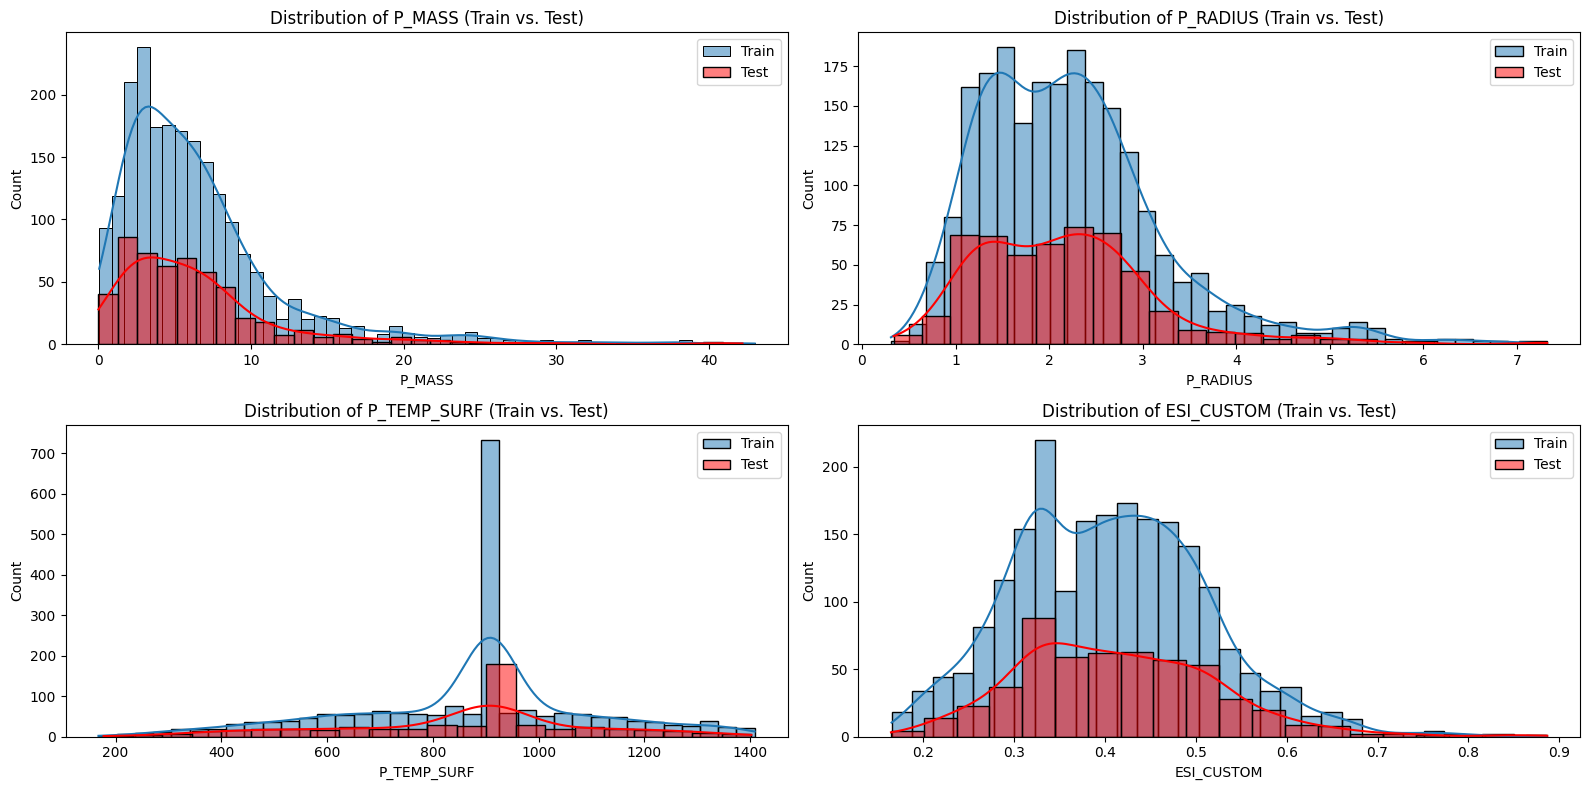

In [42]:
key_features = ['P_MASS', 'P_RADIUS', 'P_TEMP_SURF', 'ESI_CUSTOM']

plt.figure(figsize=(16, 8))
for i, feature in enumerate(key_features):
    plt.subplot(2, 2, i + 1)
    sns.histplot(X_train[feature], label='Train', kde=True)
    sns.histplot(X_test[feature], label='Test', kde=True, color='red')
    plt.title(f'Distribution of {feature} (Train vs. Test)')
    plt.legend()
plt.tight_layout()
plt.show()


 Histograms with KDE plots compare feature distributions in training and testing sets. Large differences could indicate overfitting.

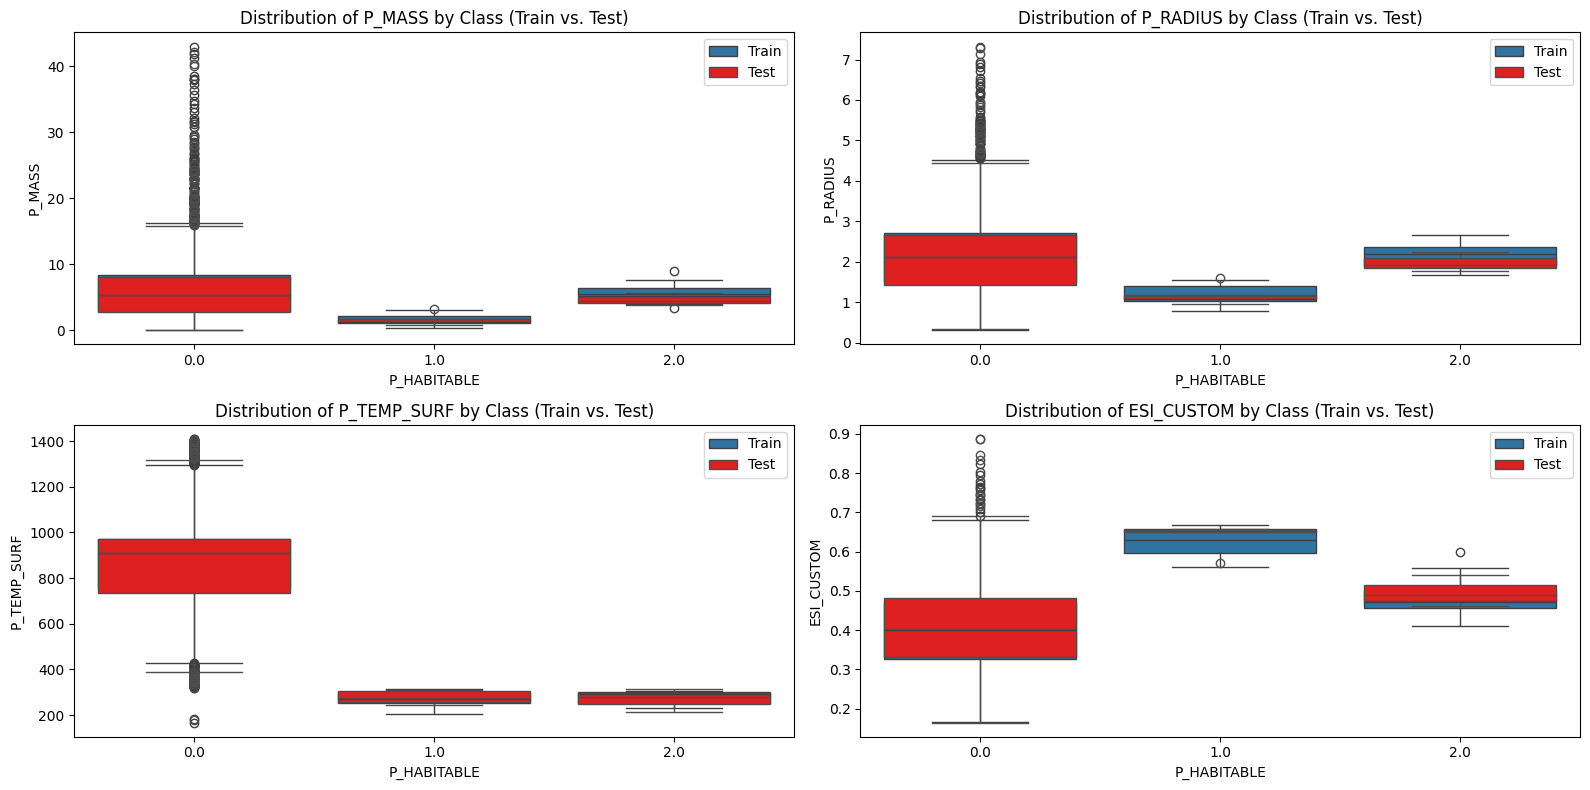

In [43]:
plt.figure(figsize=(16, 8))
for i, feature in enumerate(key_features):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x=y_train, y=X_train[feature], label='Train')
    sns.boxplot(x=y_test, y=X_test[feature], label='Test', color='red')
    plt.title(f'Distribution of {feature} by Class (Train vs. Test)')
    plt.legend()
plt.tight_layout()
plt.show()


 Box plots compare feature distributions within each class for training and testing data. Differences suggest overfitting.

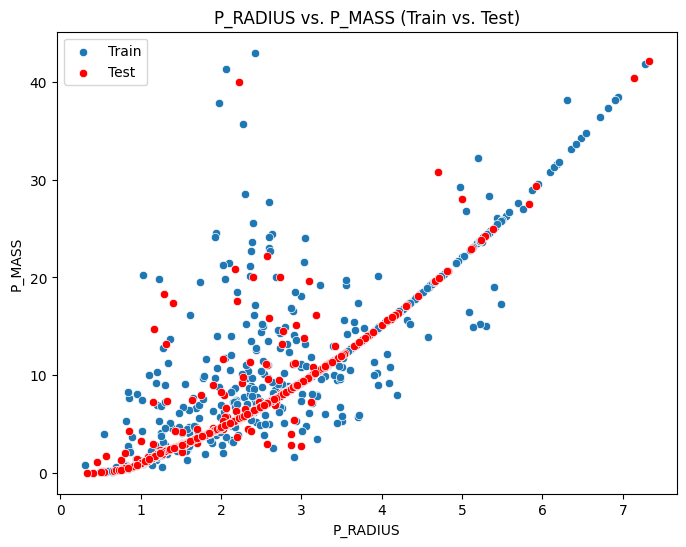

In [44]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train['P_RADIUS'], y=X_train['P_MASS'], label='Train')
sns.scatterplot(x=X_test['P_RADIUS'], y=X_test['P_MASS'], label='Test', color='red')
plt.title('P_RADIUS vs. P_MASS (Train vs. Test)')
plt.xlabel('P_RADIUS')
plt.ylabel('P_MASS')
plt.legend()
plt.show()


 A scatter plot checks if the relationship between `P_RADIUS` and `P_MASS` is consistent between training and testing.

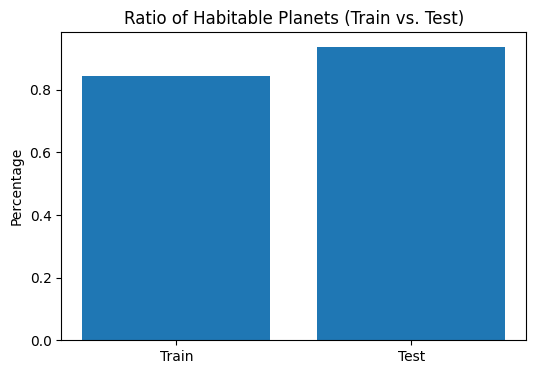

In [45]:
# Calculate the ratio of habitable planets in the training set
train_habitable_ratio = y_train.value_counts(normalize=True)[1] * 100

# Calculate the ratio of habitable planets in the test set
test_habitable_ratio = y_test.value_counts(normalize=True)[1] * 100

# Create a bar plot to compare the ratios
plt.figure(figsize=(6, 4))
plt.bar(
    ['Train', 'Test'], [train_habitable_ratio, test_habitable_ratio]
)
plt.title('Ratio of Habitable Planets (Train vs. Test)')
plt.ylabel('Percentage')
plt.show()


 Calculates and visualizes the ratio of potentially habitable planets (class 1) in training and testing.  Checks for stratification issues.


 ### Create Weighted Habitability Index

In [46]:
importances = rf.feature_importances_
feature_names = X.columns


 Retrieves feature importances and names from the trained Random Forest.

In [47]:
normalized_importances = importances / np.sum(importances)


 Normalizes importances to sum to 1, creating relative weights.

In [48]:
feature_weights = dict(zip(feature_names, normalized_importances))


 Creates a dictionary mapping feature names to normalized importances (weights).

In [49]:
selected_features = [
    'P_TEMP_SURF',
    'P_TEMP_EQUIL',
    'P_TYPE_TEMP_Hot',
    'P_FLUX',
    'TEMP_DIFF_FROM_OPTIMAL',
    'ESI_CUSTOM',
    "ESI_REVISED",
    'S_LUMINOSITY',
    'S_SNOW_LINE',
    'ATMOSPHERIC_RETENTION',
    'S_LOG_LUM',
]


 Selects features for inclusion in the Habitability Index, based on relevance and model performance.

In [50]:
df_encoded['HABITABILITY_INDEX'] = 0
for feature in selected_features:
    if feature in feature_weights:
        df_encoded['HABITABILITY_INDEX'] += (
            df_encoded[feature] * feature_weights[feature]
        )
    else:
        print(f"Warning: Feature '{feature}' not found in feature_weights.")


 Calculates the Habitability Index.  Each selected feature's value is multiplied by its weight, and the results are summed.

In [51]:
scaler_hab = StandardScaler()
df_encoded['HABITABILITY_INDEX_SCALED'] = scaler_hab.fit_transform(
    df_encoded[['HABITABILITY_INDEX']]
)


 The Habitability Index is scaled using `StandardScaler`.


 ## Retrain Model with Habitability Index

In [52]:
X = df_encoded.drop('P_HABITABLE', axis=1)
y = df_encoded['P_HABITABLE']


 Redefines the feature matrix (`X`) and target variable (`y`).

In [53]:
selected_features = [
    'HABITABILITY_INDEX_SCALED',
    'P_TEMP_SURF',
    'P_TEMP_EQUIL',
    'P_TYPE_TEMP_Hot',
    'P_FLUX',
    'TEMP_DIFF_FROM_OPTIMAL',
    'ESI_CUSTOM',
    "ESI_REVISED",
    'S_LUMINOSITY',
    'S_SNOW_LINE',
    'ATMOSPHERIC_RETENTION',
    'S_LOG_LUM',
]
X = X[selected_features]


 The feature matrix `X` is restricted to features used in the index, *plus* the scaled index itself.  This is key: the model is trained using the index as a feature.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train_scaled, y_train
)

lr = LogisticRegression(
    class_weight='balanced', max_iter=1000, random_state=42
)  # class_weight='balanced'
lr.fit(X_train_resampled, y_train_resampled)

y_pred_lr = lr.predict(X_test_scaled)

print("Logistic Regression Performance with Habitability Index:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Performance with Habitability Index:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       526
         1.0       0.83      1.00      0.91         5
         2.0       1.00      1.00      1.00         3

    accuracy                           1.00       534
   macro avg       0.94      1.00      0.97       534
weighted avg       1.00      1.00      1.00       534



In [55]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
)  # class_weight='balanced'
rf.fit(X_train_resampled, y_train_resampled)

y_pred_rf = rf.predict(X_test_scaled)
print("Random Forest Performance with Habitability Index:")
print(classification_report(y_test, y_pred_rf))

Random Forest Performance with Habitability Index:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       526
         1.0       0.83      1.00      0.91         5
         2.0       1.00      1.00      1.00         3

    accuracy                           1.00       534
   macro avg       0.94      1.00      0.97       534
weighted avg       1.00      1.00      1.00       534




 The data is split, scaled, and SMOTE is applied.  Logistic Regression and Random Forest models are retrained using the *new* feature set that includes the Habitability Index.  Performance is evaluated.

In [56]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

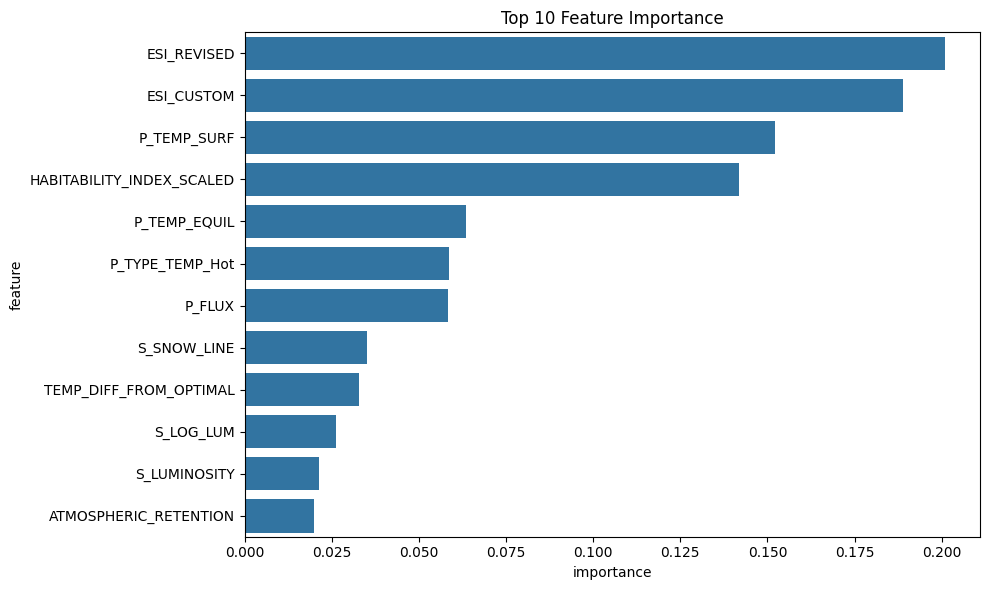

In [57]:
plt.figure(figsize=(10, 6))
top_10_features = feature_importance.head(20)
sns.barplot(x='importance', y='feature', data=top_10_features)
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.show()


 Feature importances are recalculated and visualized after retraining.

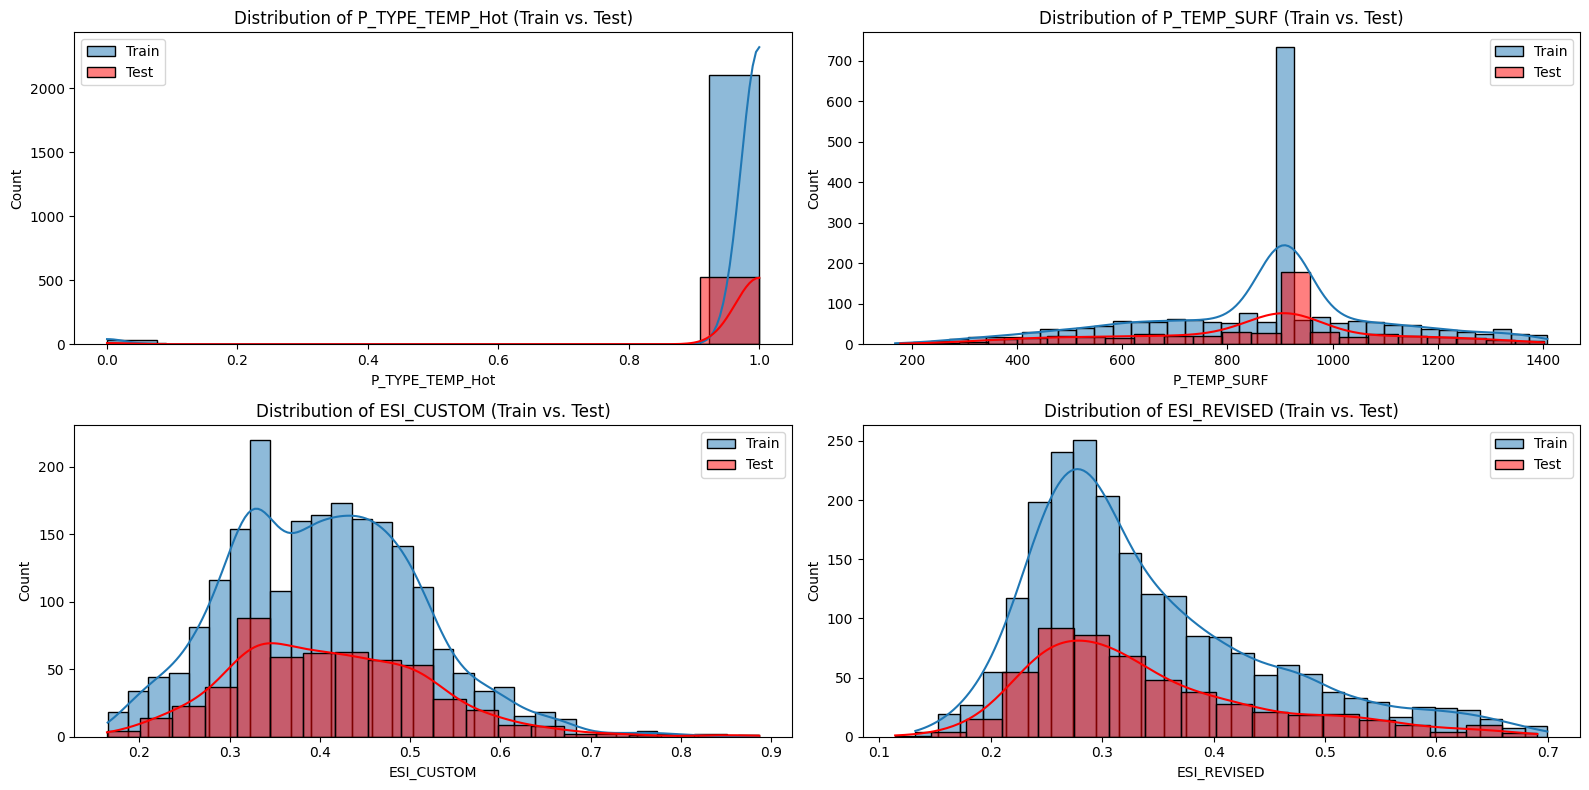

In [58]:
key_features = [ "P_TYPE_TEMP_Hot",'P_TEMP_SURF', 'ESI_CUSTOM', "ESI_REVISED"]

plt.figure(figsize=(16, 8))
for i, feature in enumerate(key_features):
    plt.subplot(2, 2, i + 1)
    sns.histplot(X_train[feature], label='Train', kde=True)
    sns.histplot(X_test[feature], label='Test', kde=True, color='red')
    plt.title(f'Distribution of {feature} (Train vs. Test)')
    plt.legend()
plt.tight_layout()
plt.show()


 Overfitting checks are repeated after retraining.


 ## Confusion Matrix

In [59]:
cm = confusion_matrix(y_test, y_pred_rf)


 The confusion matrix is calculated using the true labels (`y_test`) and the predictions from the Random Forest model (`y_pred_rf`). The confusion matrix summarizes the performance of the classification, showing the counts of true positives, true negatives, false positives, and false negatives.

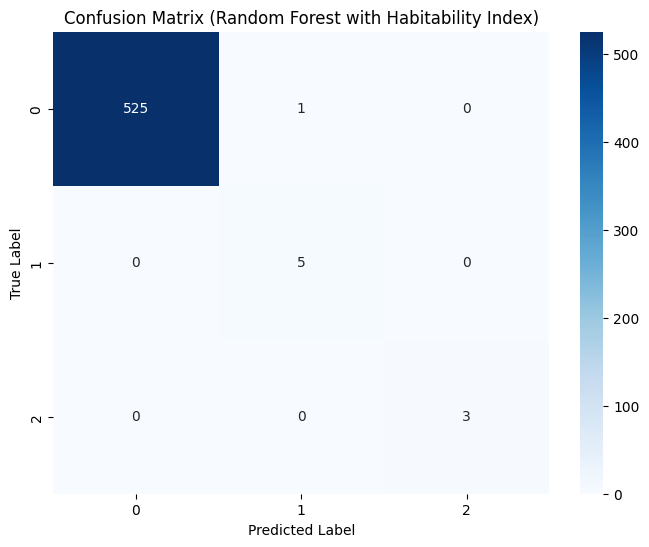

In [60]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix (Random Forest with Habitability Index)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


 The confusion matrix is visualized as a heatmap. `annot=True` displays the counts within each cell, `cmap='Blues'` provides a blue color scheme, and `fmt='d'` formats the counts as integers.  The x-axis represents the predicted labels, and the y-axis represents the true labels.  This visualization helps understand the types of errors the model is making.